# Prostate cancer prediction 

#### Data

We consider a medical study conducted on 97 men with prostate cancer.
The focus is on the relationship between the prostate specific antigen (psa), which is elevated in men with prostate cancer, and others clinical measures. 
The others clinical measures are the predictors variables, gathered in a medical examination, and the amount of expression of the antigen associated with the cancer detection is the response variable (lpsa).

Thus the data frame is made of 97 observations on 9 variables:
* lcavol: log cancer volume
* lweight: log prostate weight
* age: patient age in years
* lbph: log amount of benign prostatic hyperplasia
* svi: seminal vesicle invasion
* lcp: log of capsular penetration
* gleason: Gleason score
* pgg45: percent of Gleason score 4 or 5
* lpsa: log prostate specific antigen

The goal is to find models predicting the response lpsa.

#### Models

The data are represented by $n$ points in $p$ dimensions, thus the predictor variable is written $X\in\mathbb{R}^{n\times p}$ and the response variable is $y\in\mathbb{R}^n$.

In this work, we're insterested in the relationship between the predictor $X$ and the response $y$.
To determine this relationship, we adopt regression models.
The standard baseline is achieved with linear regression and we compare results for regularized regressions: **Ridge regression**, **Lasso** and **Elastic Net**.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


## Data exploration

In [5]:
lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')
lpsa_data = lpsa_data.loc[:, 'lcavol':]
lpsa_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [6]:
lpsa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 6.9 KB


In [7]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


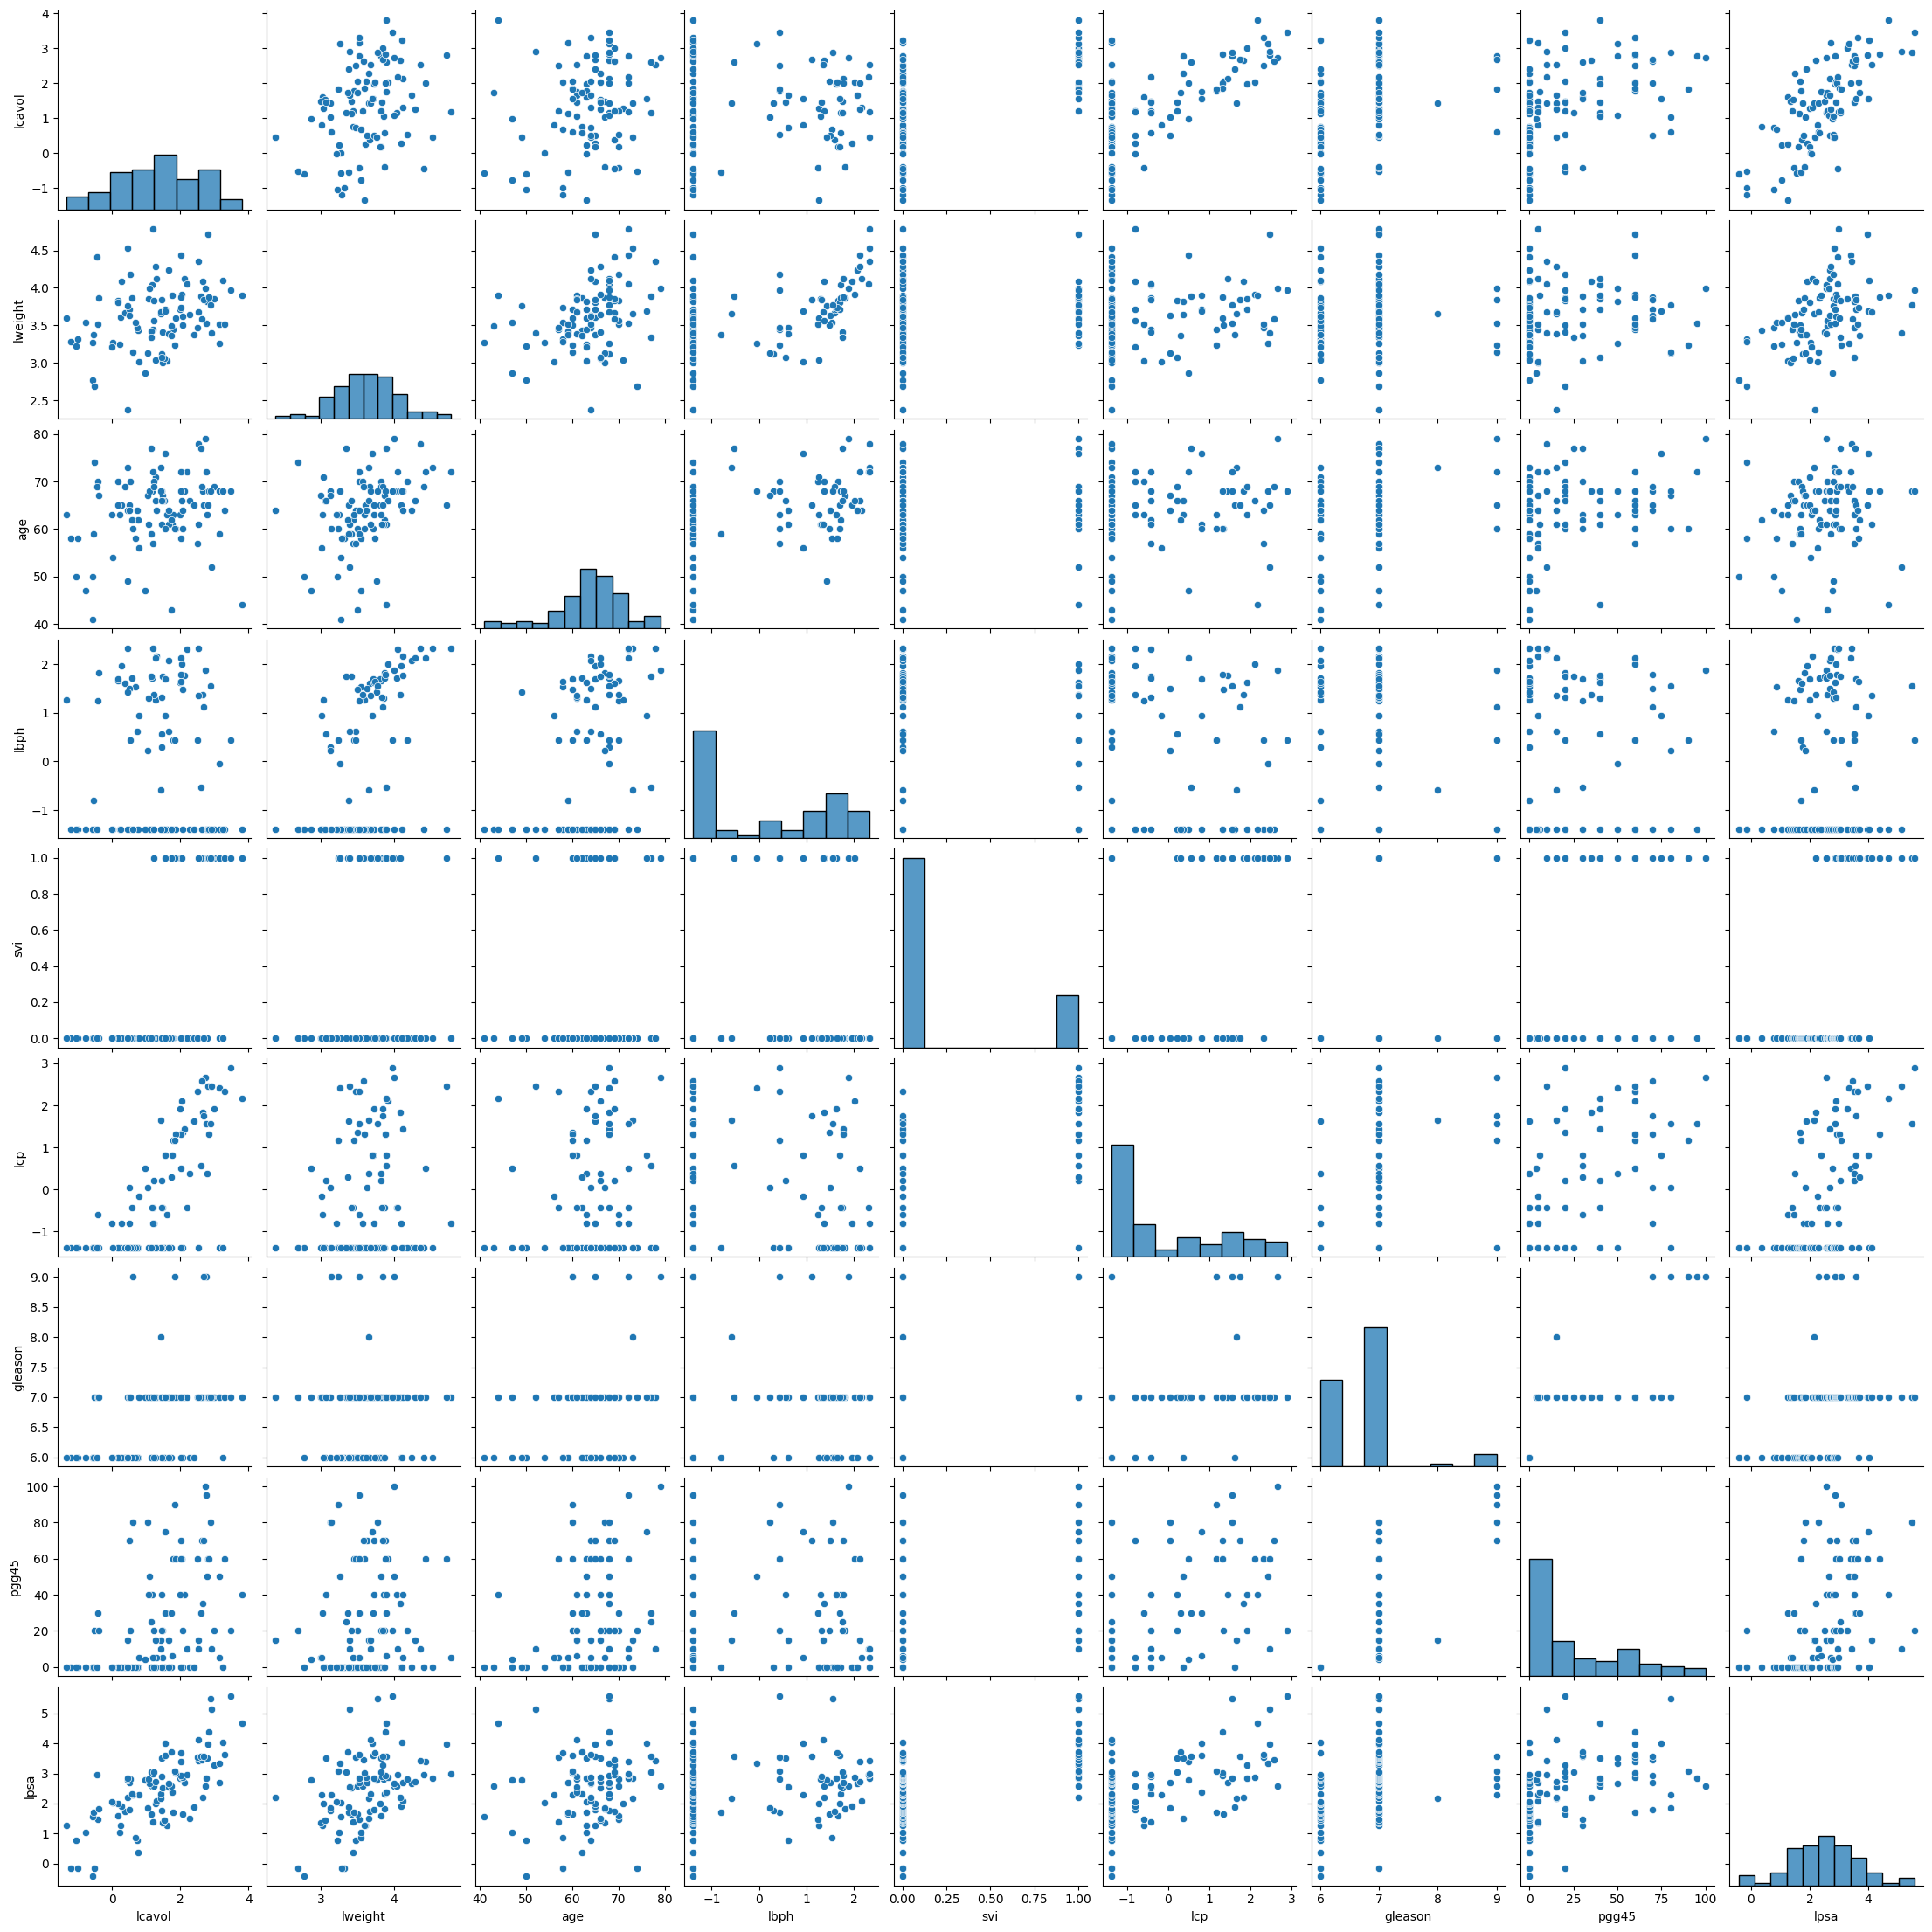

In [8]:
sns.pairplot(lpsa_data);

* lpsa is almost normally distributed.
* the presence of svi is binary
* lcp: due to not proper measurements, for small values of capsular penetration, it has been arbitrarily set to -1.25.
* gleason and pgg45 don't seem to be correlated...

Let see the correlation between variables.

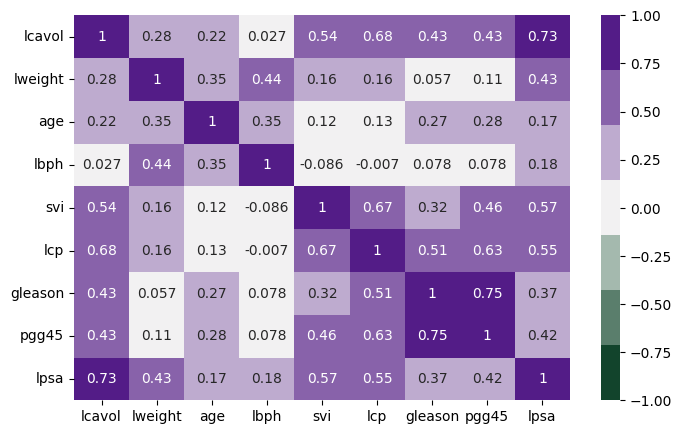

In [5]:
#### CODE
# sns.diverging_palette(145, 280, s=85, l=25, n=7)
plt.figure(figsize=(8,5))
sns.heatmap(lpsa_data.corr(),
           vmin=-1,
           vmax=1,
           cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
           annot=True);

* The more correlated variable with the response lpsa is lcavol.
  Thus in a data analysis, the lcavol variable must be included as a predictor.

* The correlation matrix shows that gleason and pgg45 are actually correlated. 
  Indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score.

Let plot the relationship between the response lpsa and the lcavol feature.

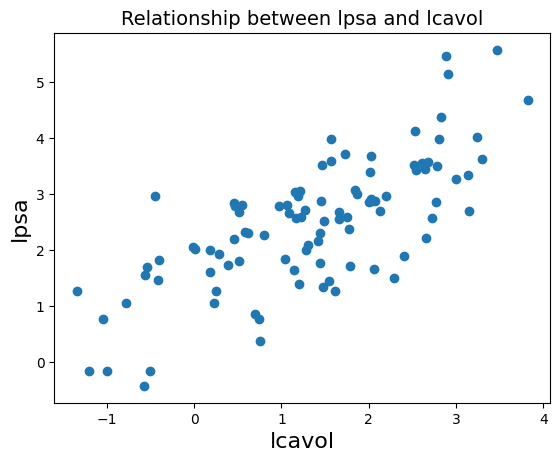

In [6]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

There is a pretty clear linear relationship with positive correlation, as seen on the correlation matrix.

### Data train/test splitting

In [9]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


In [11]:
# train : the first rows 
# test : the last rows 
n_split = 60
X_train = lpsa_data.iloc[:n_split,0:-2] # without pgg45
X_test = lpsa_data.iloc[n_split:,0:-2]
y_train = lpsa_data.iloc[:n_split,-1] # lpsa column
y_test = lpsa_data.iloc[n_split:,-1]  # lpsa column

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60, 7)
(60,)
(37, 7)
(37,)


# Learning models


# 1) Linear regression baseline

The linear regression attemps to model the relationship between the predictors variables $X$ and the response variable $y$.
It consists in finding a linear function $f:\mathbb{R}^p \to \mathbb{R}$ which predicts the response $y_i$ from the predictors $X_{i1},...,X_{ip}$ given $n$ observations for $i=1,...,n$.

In Python, the linear regression is implemented as  [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in the linear_model module of scikit-learn.

In [26]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test MAE:",  metrics.mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))
print("Test MAPE:", metrics.mean_absolute_percentage_error(y_test, y_pred))
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

Train MSE: 0.2877748864599949
Test MSE: 2.864149965701442
Test MAE: 1.4009272814377507
Test RMSE: 1.6923799708403082
Test MAPE: 0.37174130628893737
0.5551635475857004
-4.642928683864814


# 2) Regularization

In order to avoid over-learning, the regularization method allows to control the model complexity.
The model minimizes the error plus a regularization term $\lambda Reg(\beta)$ measuring the complexity, where $Reg(\beta)$ is a penalty term and $\lambda$ is an hyper-parameter.
The hyper-parameter controls the relative influence of the error term and the amount of regularization.
The optimal value of $\lambda$ can be found by cross validation (see repository [cross-validation](https://github.com/christelle-git/cross-validation/)). 

## 2.1) Ridge regression 

In the Ridge regression, the regularization term is $Reg(\beta) = ||\beta||_2^2$.
The Ridge regression allows to reduce the magnitude of the weights $\beta_i$ of the linear regression, and thus avoid over-learning.
The Ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [27]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 40)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE con regularización: 0.37
Test MSE con regularización: 2.24


In [ ]:
n_alphas = 100
alphas = np.logspace(4, 3, n_alphas) 
print(np.min(alphas))
print(np.max(alphas))

0.0001
1000.0


In [39]:
alphas_2 = np.arange(0, 200, 2)

In [40]:
alphas_2

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198])

In [30]:
alphas

array([1.00000000e-04, 1.17681195e-04, 1.38488637e-04, 1.62975083e-04,
       1.91791026e-04, 2.25701972e-04, 2.65608778e-04, 3.12571585e-04,
       3.67837977e-04, 4.32876128e-04, 5.09413801e-04, 5.99484250e-04,
       7.05480231e-04, 8.30217568e-04, 9.77009957e-04, 1.14975700e-03,
       1.35304777e-03, 1.59228279e-03, 1.87381742e-03, 2.20513074e-03,
       2.59502421e-03, 3.05385551e-03, 3.59381366e-03, 4.22924287e-03,
       4.97702356e-03, 5.85702082e-03, 6.89261210e-03, 8.11130831e-03,
       9.54548457e-03, 1.12332403e-02, 1.32194115e-02, 1.55567614e-02,
       1.83073828e-02, 2.15443469e-02, 2.53536449e-02, 2.98364724e-02,
       3.51119173e-02, 4.13201240e-02, 4.86260158e-02, 5.72236766e-02,
       6.73415066e-02, 7.92482898e-02, 9.32603347e-02, 1.09749877e-01,
       1.29154967e-01, 1.51991108e-01, 1.78864953e-01, 2.10490414e-01,
       2.47707636e-01, 2.91505306e-01, 3.43046929e-01, 4.03701726e-01,
       4.75081016e-01, 5.59081018e-01, 6.57933225e-01, 7.74263683e-01,
      

In [45]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [42]:
err_ridge

[2.864149965701439,
 2.22937514881448,
 2.116549879098436,
 2.079385839956198,
 2.066770291851757,
 2.065067688429059,
 2.069126686472383,
 2.076560701711172,
 2.086102873769418,
 2.097012658639484,
 2.1088255222976824,
 2.121234309608594,
 2.1340276769998363,
 2.1470557299174984,
 2.1602096718322144,
 2.1734091460451483,
 2.186594033836294,
 2.19971895426173,
 2.212749466765508,
 2.2256593835706306,
 2.23842882659657,
 2.2510427966053883,
 2.2634901026065863,
 2.275762549591275,
 2.2878543147003185,
 2.299761462944032,
 2.3114815676791682,
 2.323013410682096,
 2.334356743362034,
 2.345512095400838,
 2.356480620509883,
 2.367263971470541,
 2.3778641984479734,
 2.388283665925347,
 2.3985249846268526,
 2.408590955573475,
 2.41848452400963,
 2.4282087413978153,
 2.4377667340355904,
 2.447161677129194,
 2.456396773378974,
 2.4654752353071494,
 2.4744002706984287,
 2.483175070636322,
 2.4918027997087178,
 2.5002865880297223,
 2.508629524784629,
 2.516834653053827,
 2.5249049657116176,
 2.53

In [33]:
min(err_ridge)

2.0650575013210712

In [29]:
np.array(err_ridge).argmin()

70

In [30]:
alphas[np.array(err_ridge).argmin()]

8.902150854450374

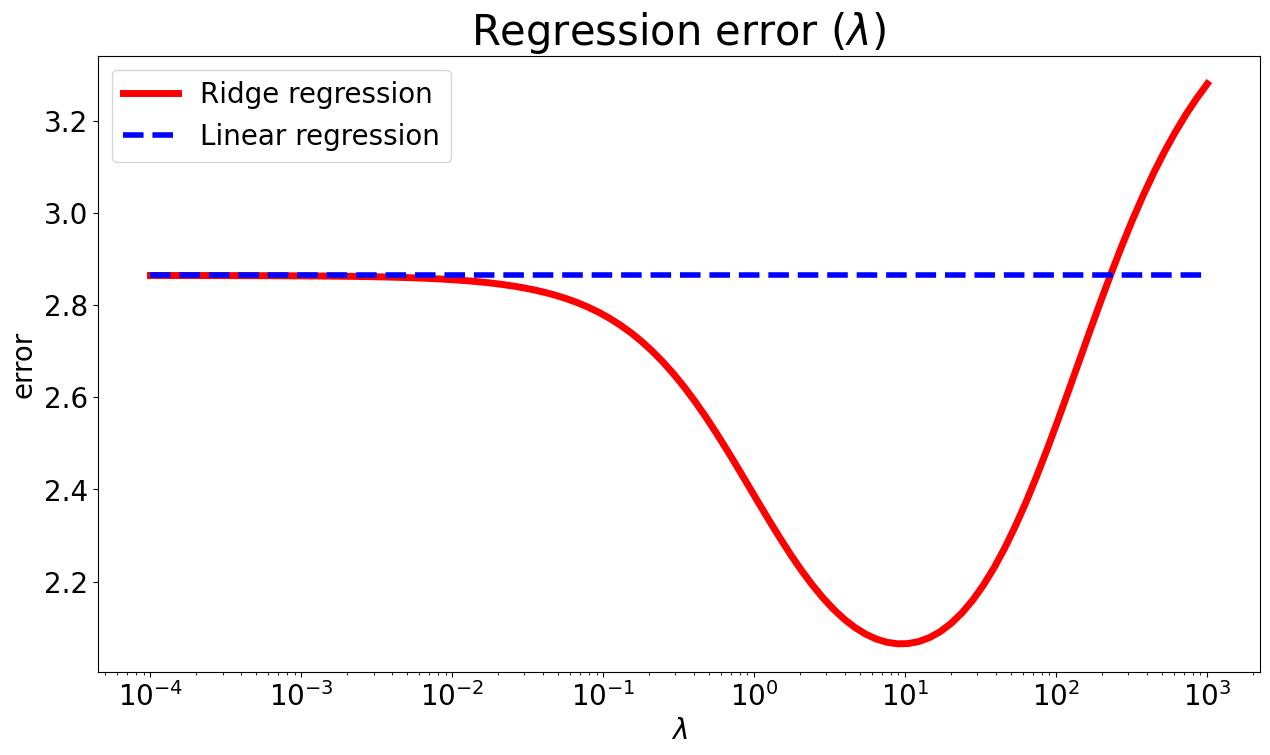

In [47]:
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('error', fontsize=20)
ax.legend(fontsize=20)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [35]:
from sklearn.linear_model import Ridge 
  
# Train the model  
ridgeR = Ridge(alpha = 10) 
ridgeR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, ridgeR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, ridgeR.predict(X_test)))

Train MSE: 0.3160
Test MSE: 2.0651


* The optimal value of the regularization coefficient $\lambda$ is around 10.
* For $\lambda \to 0$ the regularization terms vanishes leading to the same result as linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates.

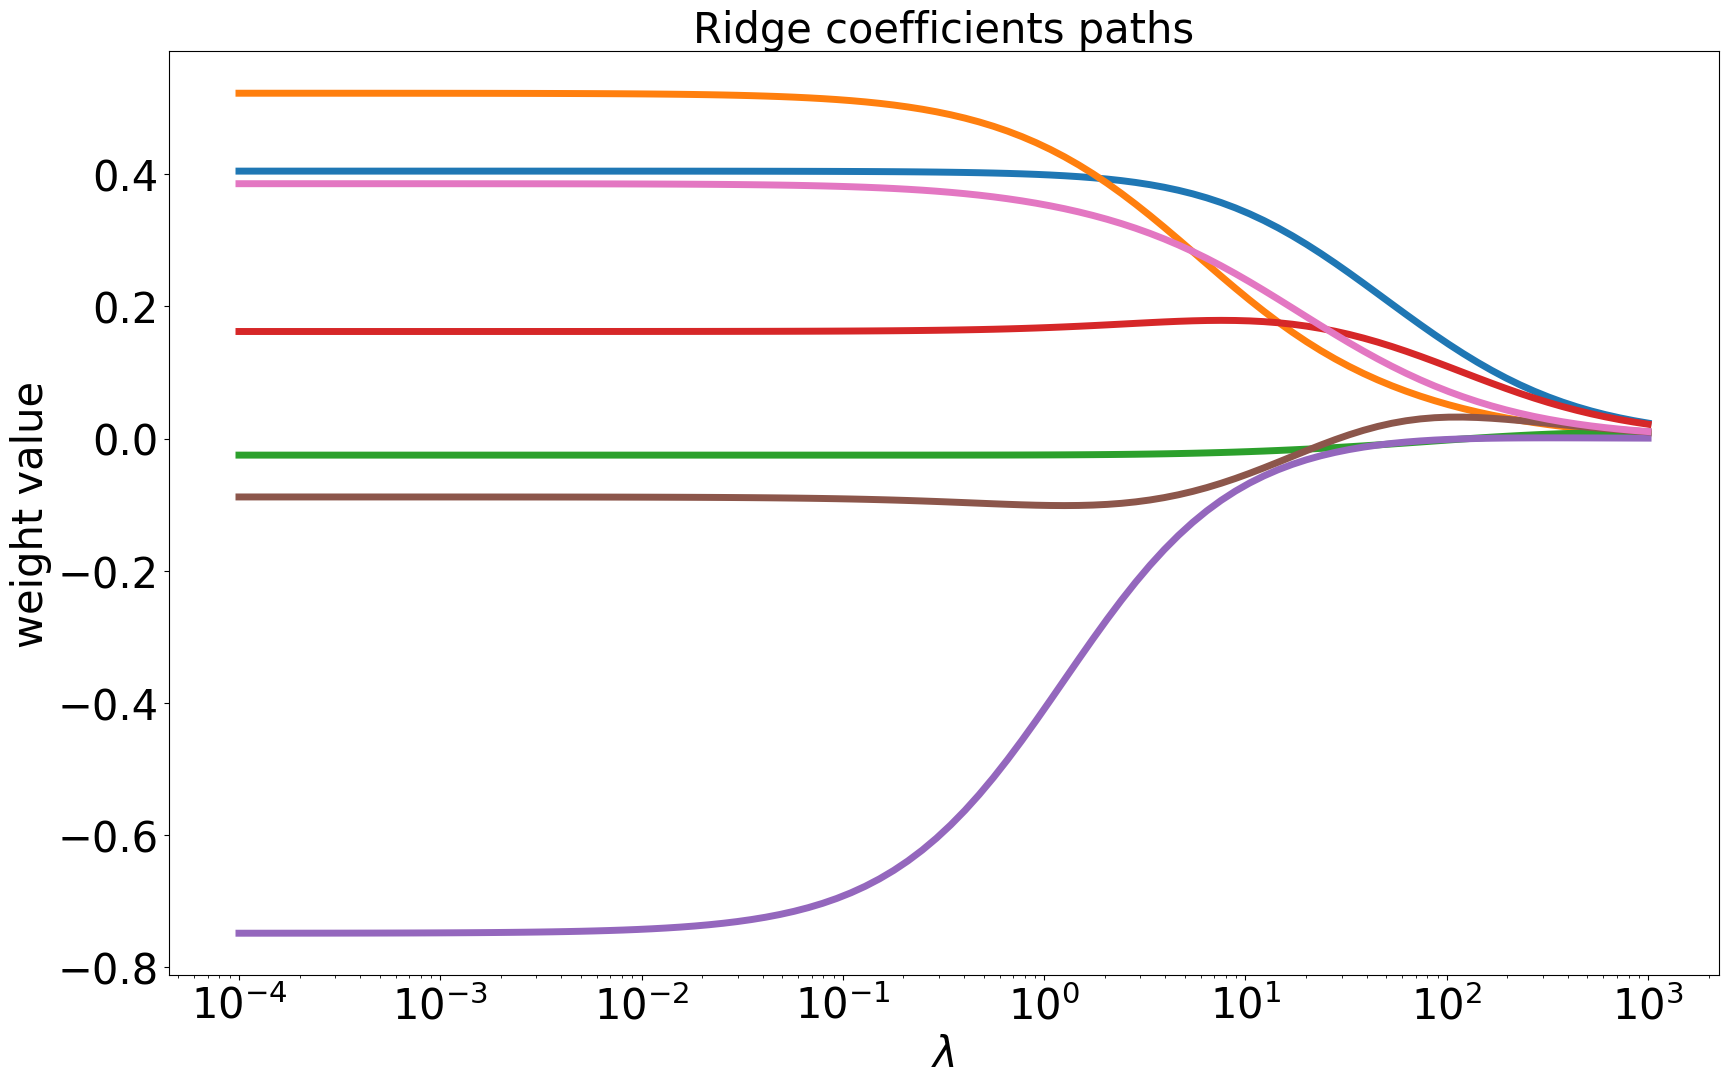

In [36]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

* The ridge regression restricts somes variables by reducing their weights magnitude.

## 2.2) Least Absolute Shrinkage and Selection Operator

The following method goes further by selecting some variables to be removed from the Ridge regression, thus reducing the dimension.
The method is called Least Absolute Shrinkage and Selection Operator (Lasso) and the resulting simplified model is a **sparse model** or parsimonious model.
In the Lasso, the regularization term is defined by $Reg(\beta) = ||\beta||_1$.

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero.
The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [48]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=0.1)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE sin regularización: 0.29
Test MSE sin regularización: 2.86
Train MSE: 0.3740
Test MSE: 2.0788


In [49]:
lasso = linear_model.Lasso(fit_intercept=False)

coef_lasso = []
err_lasso = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)    
    err_lasso.append(lasso_error)

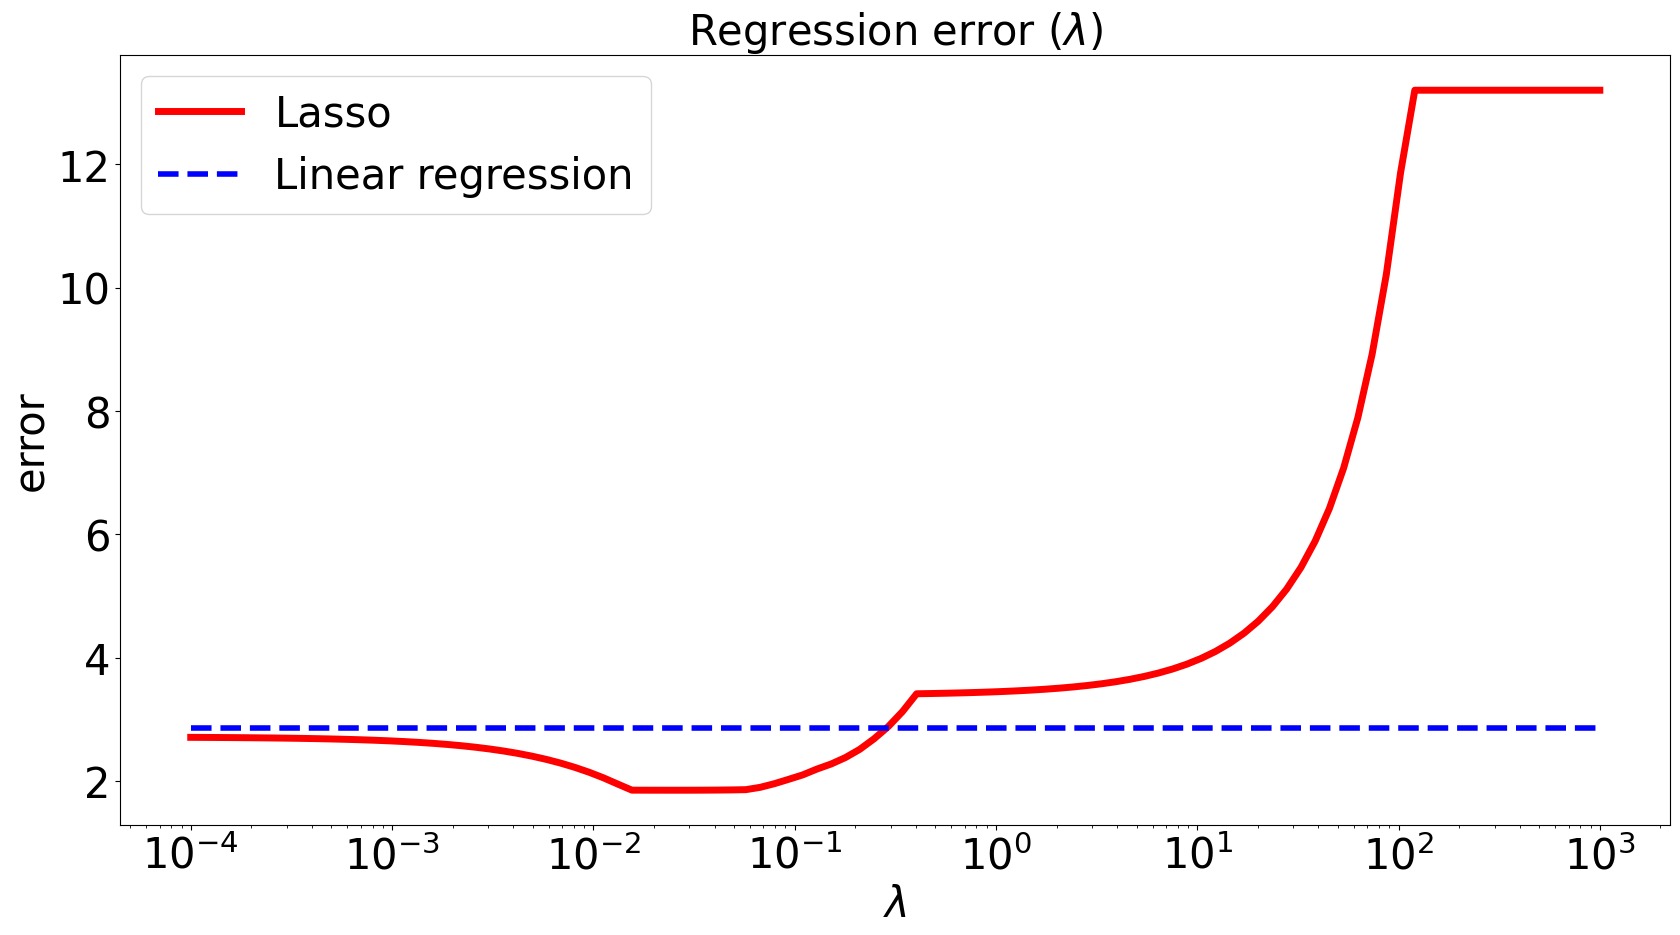

In [50]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [51]:
lassoR = Lasso(alpha = 0.02) 
lassoR.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


In [52]:
print("Test MAPE: %0.4f" % metrics.mean_absolute_percentage_error(y_test, lassoR.predict(X_test)))

Test MAPE: 0.3103


* The optimal value of the regularization coefficient $\lambda$ is between $10^{-2}$ and $10^{-1}$.
* For $\lambda \to 0$ the regularization terms vanishes so the Lasso regression tends to the linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates the error.

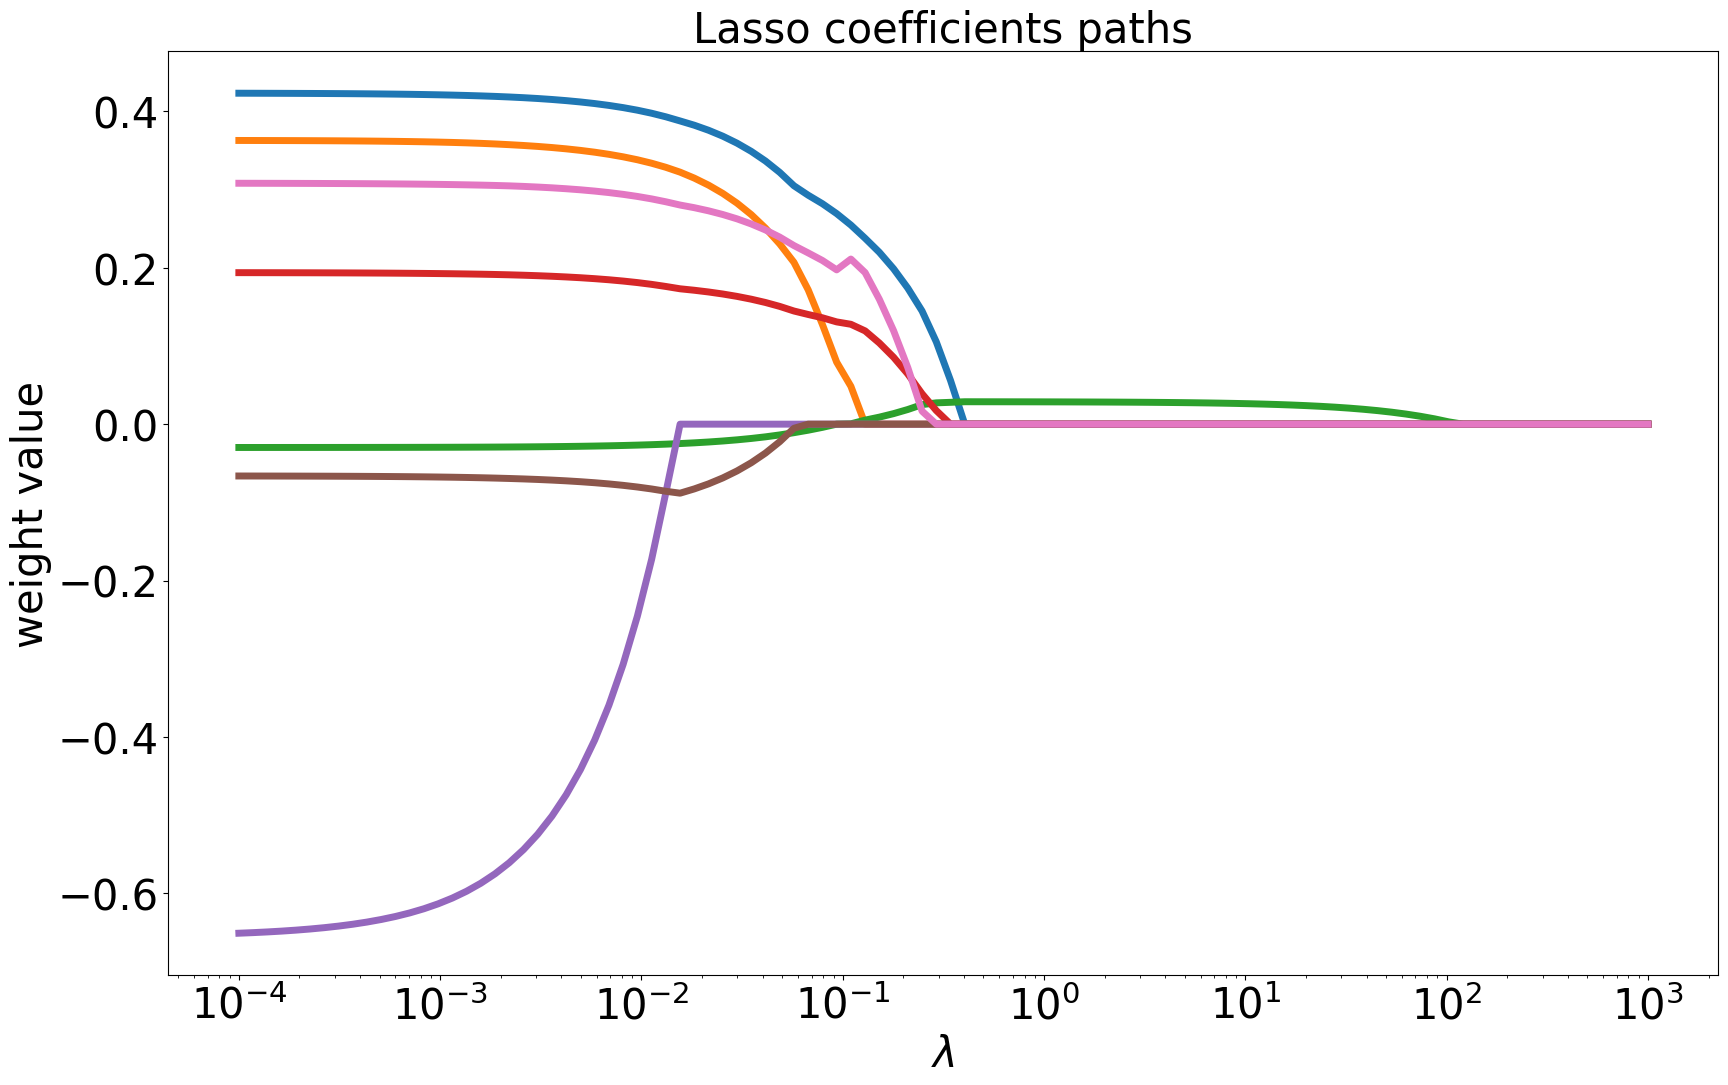

In [45]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

* The Lasso removes somes variables by putting their weight to zero.<br>
  This is the case if two variables are correlated.
* As $\lambda \to \infty$ weights vanish so the model becomes very **sparse**.

## 2.3) Elastic net

The Elastic Net method is a hybrid of the Ridge regression and the Lasso, thus overcomes the issue of losing information.
The regularization term combines both the $L_1$ and the $L_2$ regularizations.
More precisely, the regularisation term is set to $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ where $\alpha$ is an additional parameter to fit.

The Elastic net has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression.
Thus the Elastic net model is less sparse than the Lasso, keeping more information. 
However the model is more demanding in computational resources.

In what follows we present results for $\alpha=0.5$.

In [55]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 1, l1_ratio = 0.5)
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.6375
Test MSE: 3.5183


In [65]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)
    

In [57]:
min(err_eln)

1.8512304850728976

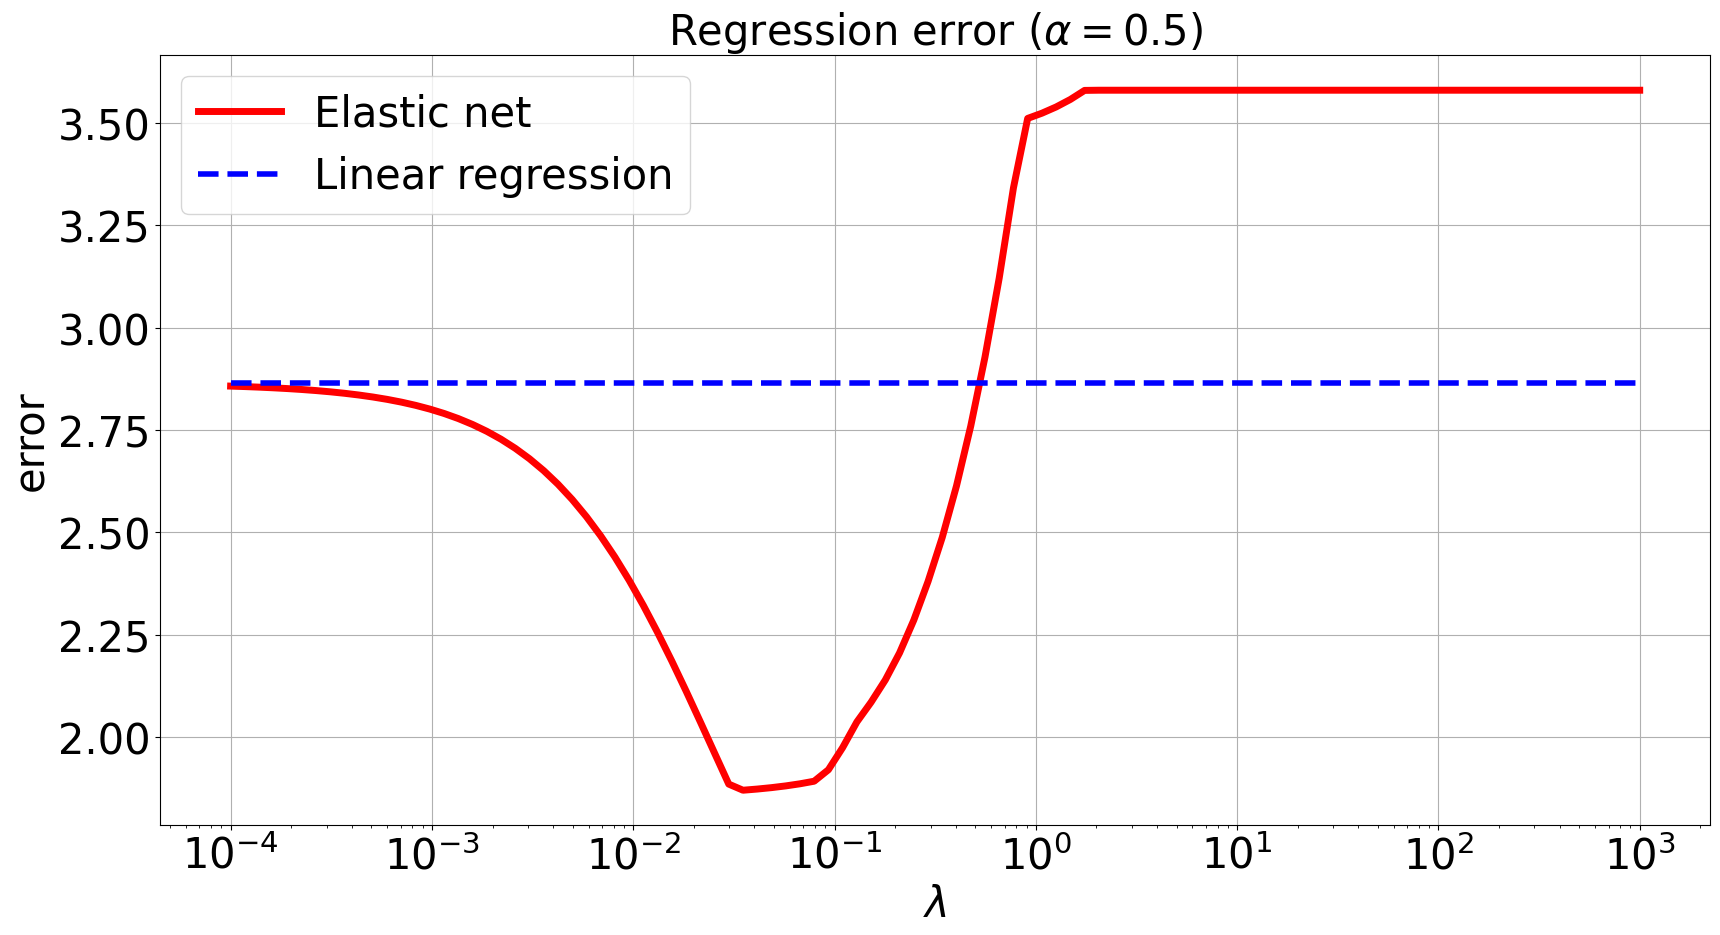

In [66]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

In [51]:
elastic_net = ElasticNet(alpha = 0.02, l1_ratio=1)
elastic_net.fit(X_train, y_train) 

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))

Train MSE: 0.3061
Test MSE: 1.8514


* The optimal value of the regularization coefficient $\lambda$ is between $10^{-2}$ and $10^{-1}$.
* For $\lambda \to 0$ the regularization terms vanishes leading to the same result as linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates the error which is smaller than with the Lasso.

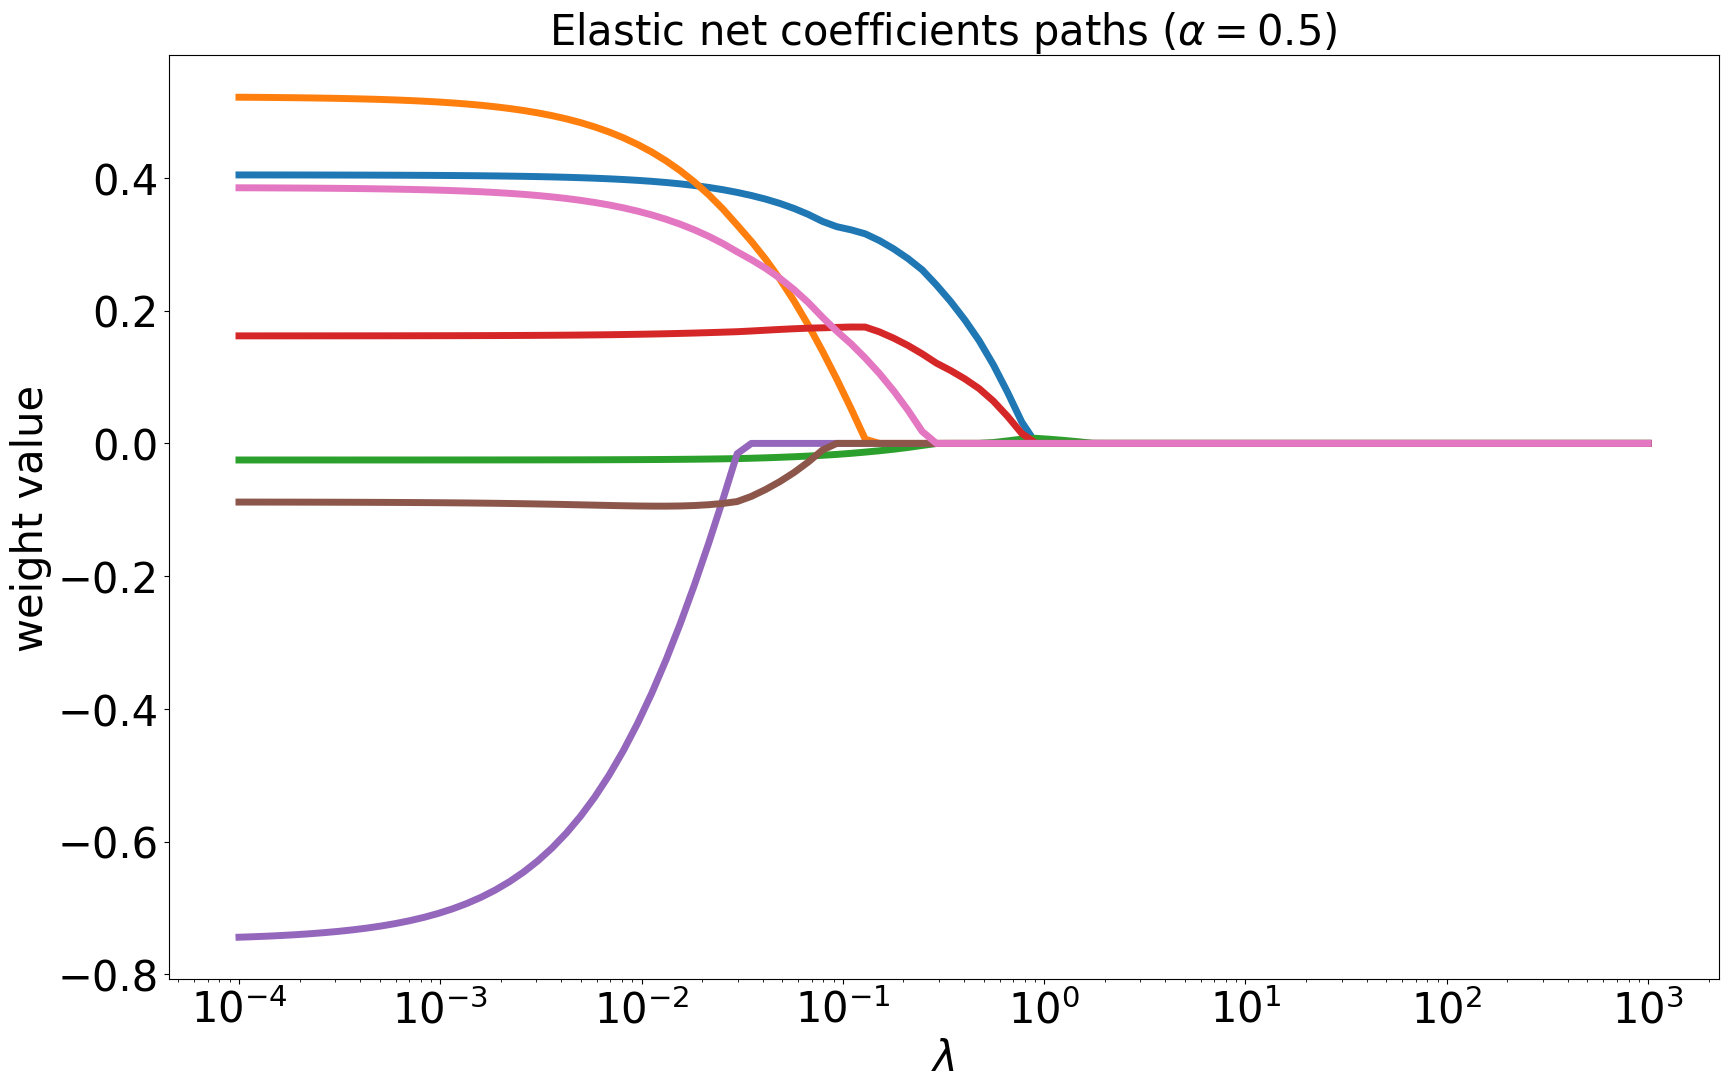

In [67]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

* As expected the Elastic net keeps more variables than the Lasso.
* Better performance can be obtained by varying the hyper-parameter $\alpha$ value.


<br>

# Model selection 

In [53]:
print("Linear regression error:   %0.4f" % baseline_error)
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   2.8641
Minimun ridge error:       2.0651
Minimum lasso error:       1.8531
Minimum elastic net error: 1.8512


* The Lasso performs better than others methods (Elastic net: $\alpha=0.5$). 
* The Lasso is more parsimonious but there is likely to be a loss of accuracy.
* The Elastic net performs better than the Ridge regression (with $\alpha=0.5$).
* The Elastic net can be tuned to outperform Lasso but it is more demanding in computational resources.

**=> The Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso**.


In order to optimize the model by fitting the optimal parameters, a cross validation can be performed.
The functions sklearn.linear_model.RidgeCV, sklearn.linear_model.LassoCV and sklearn.linear_model.ElasticNetCV in Python perform an automatic tunning of hyperparameters for the Rigde regression, the Lasso and the Elastic Net respectively.